# Final Code for IDAO - Training XGBOOST Model

# Part 1. Data Preprocessing

In [4]:
import pandas as pd
import numpy as np
import re
import os
import xgboost
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import swifter
from idao_util import utils
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [2]:
# Short cut for loading all preprocessed data
#data = pd.read_hdf('train_full.hdf')

In [5]:
# Please put the hdf files in root directory
data = pd.read_hdf('train_part_1_v2.hdf')
data = pd.concat([data,pd.read_hdf('train_part_2_v2.hdf')])

In [6]:
# Feature eng.
data['FOI_hits_b1_num']= data['FOI_hits_S'].apply(lambda x:list(x).count(1))
data['FOI_hits_b2_num']= data['FOI_hits_S'].apply(lambda x:list(x).count(2))
data['FOI_hits_b3_num']= data['FOI_hits_S'].apply(lambda x:list(x).count(3))
data['FOI_hits_b4_num']= data['FOI_hits_S'].apply(lambda x:list(x).count(4))
data['FOI_hits_DX_ave']= data['FOI_hits_DX'].apply(lambda x:np.mean(x))
data['FOI_hits_DY_ave']= data['FOI_hits_DY'].apply(lambda x:np.mean(x))
data['FOI_hits_DZ_ave']= data['FOI_hits_DZ'].apply(lambda x:np.mean(x))
data['FOI_hits_DT_ave']= data['FOI_hits_DT'].apply(lambda x:np.mean(x))

In [7]:
# Calc total time
data['MatchedHit_T'] = data['MatchedHit_T[0]'] + data['MatchedHit_T[1]'] + data['MatchedHit_T[2]'] + data['MatchedHit_T[3]']

In [8]:
closest_hits_features = data.swifter.apply(
    utils.find_closest_hit_per_station, result_type="expand", axis=1)

Pandas Apply: 100%|██████████| 5445705/5445705 [45:31<00:00, 1993.82it/s]


In [9]:

data = pd.concat(
    [data.loc[:, utils.SIMPLE_FEATURE_COLUMNS+['weight','FOI_hits_b1_num','FOI_hits_b2_num','FOI_hits_b3_num','FOI_hits_b4_num','label',
                                              'MatchedHit_T','FOI_hits_DX_ave','FOI_hits_DY_ave','FOI_hits_DZ_ave','FOI_hits_DT_ave','particle_type'],
             ],
     closest_hits_features], axis=1)

In [ ]:
# Saving data in case of reload (skip all preprocessing)

#data.to_hdf('train_full.hdf', key='data', mode='w')

In [10]:
label = data['label'].values
data = data.drop(['label'],axis = 1)

In [11]:
label_encoder = LabelEncoder()
data['ndof'] = label_encoder.fit_transform(data['ndof'])

In [12]:
data_columns = ['MatchedHit_TYPE[0]','MatchedHit_TYPE[1]','MatchedHit_TYPE[2]','MatchedHit_TYPE[3]']

In [13]:
data = pd.get_dummies(data,columns=data_columns)

In [14]:
# Feature Engineering 2
data['Missing_[2]'] = data['MatchedHit_X[2]'].apply(lambda x: int(x == -9999))
data['Missing_[3]'] = data['MatchedHit_X[3]'].apply(lambda x: int(x == -9999))
data['Missing_DT[0]'] = data['MatchedHit_DT[0]'].apply(lambda x: int(x == -1))
data['Missing_DT[1]'] = data['MatchedHit_DT[1]'].apply(lambda x: int(x == -1))
data['Missing_DT[2]'] = data['MatchedHit_DT[2]'].apply(lambda x: int(x == -1))
data['Missing_DT[3]'] = data['MatchedHit_DT[3]'].apply(lambda x: int(x == -1))

In [15]:
# Feature Engineering 3
data['sum_cl'] = data['ncl[0]'] + data['ncl[1]'] + data['ncl[2]'] + data['ncl[3]']
data['sum_cs'] = data['avg_cs[0]'] + data['avg_cs[1]'] + data['avg_cs[2]'] + data['avg_cs[3]']

In [17]:
# cure data
data[24] = data[24].apply(lambda x: 0 if np.isnan(x) else x)

# Part 2. Training

In [18]:
# Train - test split
X_train, X_validation,y_train,y_validation = train_test_split(data,label, test_size=0.03, shuffle=True)

In [19]:
particle_train = X_train['particle_type']
particle_validation = X_validation['particle_type']

In [20]:
X_train = X_train.drop('particle_type',axis=1)
X_validation = X_validation.drop('particle_type',axis=1)

In [21]:
import idao_util.scoring as scoring
import idao_util.utils as utils

In [22]:
# Limit the priority of the high sample weights, but retain the direction/sign 
X_train['weight']=X_train['weight'].apply(lambda x: x if abs(x) <200 else np.sign(x) * 200)

In [23]:
# Feature engineering 4 based on top features using feature importance of previous training
X_train['FE_1']= X_train['PT'] * X_train[3] 
X_train['FE_2']= X_train['sum_cs'] * X_train[6] 
X_validation['FE_1']= X_validation['PT'] * X_validation[3] 
X_validation['FE_2']= X_validation['sum_cs'] * X_validation[6] 


In [24]:
# drop weights
weight_train = X_train['weight'].values
weight_validation = X_validation['weight'].values
X_train = X_train.drop('weight',axis=1)
X_validation = X_validation.drop('weight',axis=1)


In [25]:
from idao_util import scoring

In [26]:
import gc 
gc.collect()

173

In [27]:
# Initialize xgb models (param chosen using grid search)
xgb = xgboost.XGBClassifier(max_depth= 10, gamma=0.5,min_child_weight=5,subsample=1,colsample_bytree=0.6,n_estimators=300,n_jobs=-1,verbose_eval=True)

In [28]:
eval_set = [(X_validation.values,y_validation)]


In [29]:
xgb.fit(X_train.values,
          y_train, eval_set = eval_set,
          sample_weight =weight_train,verbose = 2)

[15:19:35] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-error:0.140624
[2]	validation_0-error:0.105147
[4]	validation_0-error:0.105281
[6]	validation_0-error:0.100237
[8]	validation_0-error:0.099558
[10]	validation_0-error:0.098885
[12]	validation_0-error:0.098732
[14]	validation_0-error:0.098383
[16]	validation_0-error:0.098395
[18]	validation_0-error:0.097912
[20]	validation_0-error:0.098132
[22]	validation_0-error:0.098628
[24]	validation_0-error:0.098713
[26]	validation_0-error:0.098175
[28]	validation_0-error:0.098897
[30]	validation_0-error:0.099075
[32]	validation_0-error:0.099258
[34]	validation_0-error:0.099821
[36]	validation_0-error:0.099852
[38]	validation_0-error:0.099717
[40]	validation_0-error:0.099772
[42]	validation_0-error:0.099105
[44]	validation_0-error:0.09897
[46]	validation_0-error:0.098622
[48]	validation_0-error:0.098921
[50]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.5, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=5, missing=None,
       n_estimators=300, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, verbose_eval=True)

In [30]:
from sklearn.metrics import accuracy_score
predictions = xgb.predict_proba(X_validation.values)
accuracy_score(predictions.argmax(axis=1),y_validation)

0.9226978919276253

In [31]:
from matplotlib import pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[  8268   4568]
 [  8061 142475]]


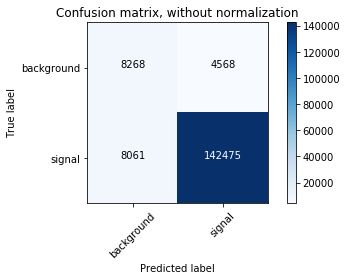

In [32]:
from sklearn.metrics import confusion_matrix
mtx = confusion_matrix(y_validation,predictions.argmax(axis=1))
plot_confusion_matrix(mtx, classes=['background','signal'],
                      title='Confusion matrix, without normalization')

In [33]:
weight_validate = np.array([x if abs(x) <200 else np.sign(x) * 200 for x in weight_validation])

In [34]:
from idao_util import scoring
predictions = xgb.predict_proba(X_validation.values)[:,1]
scoring.rejection90(y_validation, predictions, sample_weight=weight_validation)

0.7737344669398244

In [35]:
xgb.save_model("track_final.xgb")

In [36]:
import gc 
gc.collect()

3148

# Part 3. Test

In [37]:
#testdata = pd.read_hdf('test_public_v2.hdf')
testdata = pd.read_hdf('test_private_v2_track_1.hdf')

In [39]:
closest_hits_features = testdata.swifter.apply(
    utils.find_closest_hit_per_station, result_type="expand", axis=1)

Pandas Apply: 100%|██████████| 1452188/1452188 [12:15<00:00, 1974.96it/s]


Repeat feature engineering process

In [40]:
testdata['FOI_hits_b1_num']= testdata['FOI_hits_S'].apply(lambda x:list(x).count(1))
testdata['FOI_hits_b2_num']= testdata['FOI_hits_S'].apply(lambda x:list(x).count(2))
testdata['FOI_hits_b3_num']= testdata['FOI_hits_S'].apply(lambda x:list(x).count(3))
testdata['FOI_hits_b4_num']= testdata['FOI_hits_S'].apply(lambda x:list(x).count(4))

In [41]:
testdata['FOI_hits_DX_ave']= testdata['FOI_hits_DX'].apply(lambda x:np.mean(x))
testdata['FOI_hits_DY_ave']= testdata['FOI_hits_DY'].apply(lambda x:np.mean(x))
testdata['FOI_hits_DZ_ave']= testdata['FOI_hits_DZ'].apply(lambda x:np.mean(x))
testdata['FOI_hits_DT_ave']= testdata['FOI_hits_DT'].apply(lambda x:np.mean(x))

In [42]:
testdata['MatchedHit_T'] = testdata['MatchedHit_T[0]'] + testdata['MatchedHit_T[1]'] + testdata['MatchedHit_T[2]'] + data['MatchedHit_T[3]']

In [43]:
testdata = pd.concat(
    [testdata.loc[:, utils.SIMPLE_FEATURE_COLUMNS+['weight','FOI_hits_b1_num','FOI_hits_b2_num','FOI_hits_b3_num','FOI_hits_b4_num',
                                                  'MatchedHit_T','FOI_hits_DX_ave','FOI_hits_DY_ave','FOI_hits_DZ_ave','FOI_hits_DT_ave']],
     closest_hits_features], axis=1)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [44]:
testdata[24] = testdata[24].apply(lambda x: 0 if np.isnan(x) else x)

In [45]:
testdata = pd.get_dummies(testdata,columns=data_columns)

In [46]:
testdata['Missing_[2]'] = testdata['MatchedHit_X[2]'].apply(lambda x: int(x == -9999))
testdata['Missing_[3]'] = testdata['MatchedHit_X[3]'].apply(lambda x: int(x == -9999))
testdata['Missing_DT[0]'] = testdata['MatchedHit_DT[0]'].apply(lambda x: int(x == -1))
testdata['Missing_DT[1]'] = testdata['MatchedHit_DT[1]'].apply(lambda x: int(x == -1))
testdata['Missing_DT[2]'] = testdata['MatchedHit_DT[2]'].apply(lambda x: int(x == -1))
testdata['Missing_DT[3]'] = testdata['MatchedHit_DT[3]'].apply(lambda x: int(x == -1))

In [47]:
testdata['ndof'] = label_encoder.transform(testdata['ndof'])

In [48]:
testdata['sum_cl'] = testdata['ncl[0]'] + testdata['ncl[1]'] + testdata['ncl[2]'] + testdata['ncl[3]']
testdata['sum_cs'] = testdata['avg_cs[0]'] + testdata['avg_cs[1]'] + testdata['avg_cs[2]'] + testdata['avg_cs[3]']

In [49]:
testdata['FE_1']= testdata['PT'] * testdata[3] 
testdata['FE_2']= testdata['sum_cs'] * testdata[6] 

In [50]:
weight_test = testdata['weight'].values
testdata = testdata.drop(['weight'],axis=1)

In [ ]:
#xgb = xgboost.XGBClassifier()
#xgb.load_model('track_final.xgb')

In [53]:
predictions_xgb = xgb.predict_proba(testdata.values)[:,1]

In [54]:
pd.DataFrame(data={"prediction": predictions_xgb}, index=testdata.index).to_csv(
    "prediction_final.csv", index_label=utils.ID_COLUMN)